## Kaggle Fruits 360 Image Classification with Fast.ai

https://www.kaggle.com/moltean/fruits

In [1]:
## Check GPU memory availability

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - \ done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 12.9 GB  | Proc size: 139.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
## install and setup Fast.ai v.0.7.0, pytorch and dependencies

#!pip uninstall fastai
!pip install Pillow==4.1.1
!pip install "fastai==0.7.0"
!pip install torchtext==0.2.3
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
!apt update && apt install -y libsm6 libxext6

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install image

%matplotlib inline
from fastai.imports import *


    100% |████████████████████████████████| 5.7MB 6.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 122kB 8.4MB/s 
    100% |████████████████████████████████| 112kB 27.3MB/s 
    100% |████████████████████████████████| 61kB 22.8MB/s 
    100% |████████████████████████████████| 496.4MB 31kB/s 
    100% |████████████████████████████████| 122kB 22.1MB/s 
    100% |████████████████████████████████| 3.6MB 3.8MB/s 
    100% |████████████████████████████████| 184kB 29.1MB/s 
    100% |████████████████████████████████| 1.5MB 7.6MB/s 
    100% |████████████████████████████████| 71kB 24.6MB/s 
    100% |████████████████████████████████| 2.2MB 4.2MB/s 
    100% |████████████████████████████████| 11.6MB 1.9MB/s 
    100% |████████████████████████████████| 61kB 21.9MB/s 
    100% |████████████████████████████████| 92kB 28.5MB/s 
    100% |████████████████████████████████| 122kB 

In [3]:
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [4]:
import torch
print(torch.__version__)

0.3.0.post4


It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [7]:
torch.backends.cudnn.enabled

True

In [0]:
import fastai as fai
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Loading Dataset

In [0]:
DATASET_ZIP_FILE = 'fruits.zip'

In [12]:
from zipfile import ZipFile
files = os.listdir()
if not DATASET_ZIP_FILE in files:
  
#  !curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:63.0) Gecko/20100101 Firefox/63.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --cookie '_ga=GA1.3.597929118.1540370868' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-datasets/5857/94583/fruits.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1543353373&Signature=rfXrXBZSWzulX89wVMZDAe94oaVLEUrANf5DzrxnaezszFEgWrtoWzGeDjVDStAn3jdczeSknwH5uS%2BJ8Q6QJLiEqoFcB2iM0LANrl6cc6RWXynmI0NxIUqhFeL%2BngeQF1eFNivl4aCKBZDsqW7%2BtIPAWyfpcBvXKP0ACgmnJt%2Fb%2BUe7NnLWZ9c353YPK4msQAvM5H5c40kXAzYX9er6XpX7HOTUkY%2FXrVhNhmuiorDFERNHhdzmBHepDJRRhY5x34NXw3z0pk6Rn7aToBh9yqNQ8aQDeekNrBDQky9KahJmupA5DpjdK76vA3jKX29Cw%2FnAdj9w7GyKiIZ1iYtm8g%3D%3D' --output 'fruits.zip'  #The first step is install kaggle
#'''
  !pip install kaggle
  from google.colab import files
  files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  #this permissions change avoids a warnong on Kaggle tool startup
  !chmod 600 ~/.kaggle/kaggle.json  
  !kaggle datasets download -d moltean/fruits
#'''
  !ls
  with ZipFile(DATASET_ZIP_FILE, 'r') as zipF:
    zipF.extractall()
    print('UnZip Done')

    100% |████████████████████████████████| 61kB 5.6MB/s 
    100% |████████████████████████████████| 245kB 17.0MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


Saving kaggle.json to kaggle.json
 97% 395M/406M [00:07<00:00, 33.8MB/s]
100% 406M/406M [00:07<00:00, 55.4MB/s]
fruits.zip  kaggle.json  sample_data
UnZip Done


In [13]:
#lets see the imported files from kaggle dataset
!ls -l

total 415344
drwxr-xr-x 6 root root      4096 Nov 25 09:55 fruits-360
-rw-r--r-- 1 root root 425299224 Nov 25 09:55 fruits.zip
-rw-r--r-- 1 root root        62 Nov 25 09:55 kaggle.json
drwxr-xr-x 2 root root      4096 Nov 20 18:17 sample_data


In [0]:
data_dir = 'fruits-360/'
PATH = data_dir

train_dir = 'Training'
val_dir = 'Test'

In [22]:
!ls '{data_dir}'

LICENSE  papers  readme.md  Test  test-multiple_fruits	Training


# Model Architecture Selection

In [0]:
## CHOOSE ARCHITECTURE AND IMAGE SIZE

#arch = vgg16
arch = resnet34
#arch = resnext50
#arch = resnext101_64
#arch = inceptionresnetv2
#arch = inceptionv4
sz = 100
bs = 16

## First look at pictures

In [0]:
import pandas as pd
import numpy as np

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize

In [23]:
files = os.listdir(f'{data_dir}{train_dir}/Banana')[:5]
files

['91_100.jpg', '0_100.jpg', '155_100.jpg', 'r_190_100.jpg', 'r_22_100.jpg']

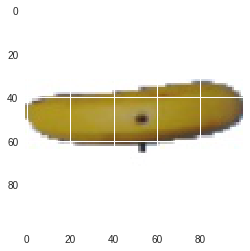

In [24]:
img = plt.imread(f'{data_dir}{train_dir}/Banana/{files[3]}')
plt.imshow(img);

Here is how the raw data looks like

In [0]:
# fast.ai functions to initialize transform and data loader objects

tfms=tfms_from_model(arch, sz)
data = ImageClassifierData.from_paths(PATH, trn_name = train_dir, val_name=val_dir, tfms=tfms, bs=bs)

In [33]:
#pick first image just for viewing
pic = PATH + data.trn_ds.fnames[0]; pic

'fruits-360/Training/Apple Braeburn/0_100.jpg'

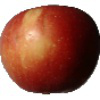

In [34]:
img = PIL.Image.open(pic); img
#img = PIL.Image.open(f'{pic}');
#img = plt.imread(pic)
#plt.imshow(img);

In [0]:
# create python data dictionary {}, path/file and image size(x,y)
# ps very long processing time
e_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [0]:
e_d

In [0]:
#!pip3 list

In [0]:
'''
#redefine zip, after ZipFile breaks it
def zip(*iterables):
    # zip('ABCD', 'xy') --> Ax By
    sentinel = object()
    iterators = [iter(it) for it in iterables]
    while iterators:
        result = []
        for it in iterators:
            elem = next(it, sentinel)
            if elem is sentinel:
                return
            result.append(elem)
        yield tuple(result)
'''        

In [0]:
import os
row_sz, col_sz = list(zip(*e_d.values()))

In [38]:
row_sz[:5]

(100, 100, 100, 100, 100)

In [0]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [40]:
col_sz[:5]

array([100, 100, 100, 100, 100])

In [41]:
# find few row/col ratios
row_sz[:5]/col_sz[:5]

array([1., 1., 1., 1., 1.])

In [42]:
print(min(row_sz), max(row_sz))

100 100


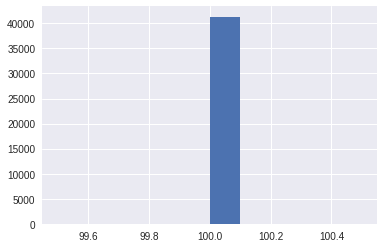

In [43]:
plt.hist(row_sz);

In [0]:
#plt.hist(row_sz[row_sz < 800])

In [46]:
# again, list total number of classes, and list them all
# os.list dir sorting depends on OS dependent file indexing, so leaving it as it is

classes = os.listdir(f'{data_dir}{train_dir}')
classes.sort()
print("Class Total Count: ", len(classes))
print(classes)

Class Total Count:  81
['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Quince', 'Rambutan', 'Raspberry',

In [49]:
# parse all classes and assemble python list object []
# each list element will contain array of files names of a class

all_images_class = [os.listdir(f'{data_dir}{train_dir}/'+c) for c in classes]
#int_to_classes = {i:classes[i] for i in range(len(classes))}
#classes_to_int = {classes[i]:i for i in range(len(classes))}
print("Classes: ",len(all_images_class) )

Classes:  81


In [50]:
# create python data dictionary {}, with key="text", and value as length(of size) of containing list object array (1D)
# gives histogram like file count for each class
dataDict= {"n_images": [len(x) for x in all_images_class]}
print("file count in each class: ",dataDict)
trainFiles = 0
for x in all_images_class:
  trainFiles = trainFiles+len(x)
print(" Total Train Files: ", trainFiles)

file count in each class:  {'n_images': [492, 492, 492, 481, 492, 492, 492, 429, 490, 492, 492, 427, 491, 490, 490, 490, 492, 492, 490, 492, 738, 738, 492, 492, 492, 490, 490, 490, 490, 492, 490, 490, 490, 492, 490, 490, 490, 466, 490, 492, 490, 490, 490, 490, 490, 490, 738, 492, 492, 479, 492, 490, 492, 492, 492, 490, 490, 490, 490, 492, 492, 490, 493, 490, 447, 492, 490, 492, 490, 490, 492, 738, 490, 490, 738, 672, 738, 479, 492, 367, 735]}
 Total Train Files:  41322


In [0]:
# assemble panda Dataframe {class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)}
# Train Data set
df = pd.DataFrame(dataDict, index=classes)
df.index.name = "Fruits"

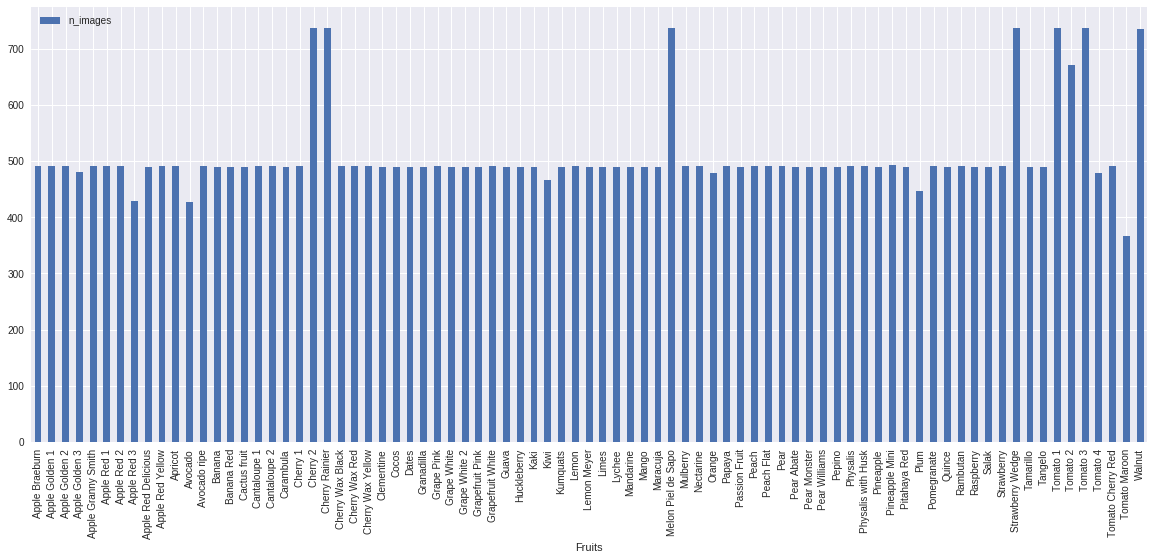

In [52]:
df.plot(kind="bar", grid=True,figsize=(20,8))

##Review: easy steps to train a world-class image classifier

 *   precompute=True
 *   Use lr_find() to find highest learning rate where loss is still clearly improving
 *   Train last layer from precomputed activations for 1-2 epochs
 *   Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
 *   Unfreeze all layers
 *   Set earlier layers to 3x-10x lower learning rate than next higher layer
 *   Use lr_find() again
 *   Train full network with cycle_mult=2 until over-fitting


In [0]:
#function to plot training and validation loss
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='b', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

## Initial Model

In [53]:
## download fast.ai pretrained network weigths, and copy to local directory

!wget http://files.fast.ai/models/weights.tgz
!tar -xvzf weights.tgz

--2018-11-25 10:18:01--  http://files.fast.ai/models/weights.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195411318 (1.1G) [text/plain]
Saving to: ‘weights.tgz’

weights.tgz         100%[===================>]   1.11G  35.7MB/s    in 32s     

2018-11-25 10:18:34 (35.2 MB/s) - ‘weights.tgz’ saved [1195411318/1195411318]

weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


In [55]:
!ls '/usr/local/lib/python3.6/dist-packages/fastai'
!cp -R weights '/usr/local/lib/python3.6/dist-packages/fastai/'

adaptive_softmax.py  initializers.py	  metrics.py	sgdr.py
column_data.py	     __init__.py	  model.py	structured.py
conv_learner.py      io.py		  models	swa.py
core.py		     layer_optimizer.py   nlp.py	text.py
dataloader.py	     layers.py		  plots.py	torch_imports.py
dataset.py	     learner.py		  __pycache__	transforms_pil.py
executors.py	     lm_rnn.py		  rnn_reg.py	transforms.py
fp16.py		     losses.py		  rnn_train.py	utils.py
imports.py	     lsuv_initializer.py  set_spawn.py	weights


In [56]:
# Get initial predictions on pre-trained network, just training last layers
# model trained on ImageNet (1.2 million images and 1000 classes) as a starting point.
'''
## Fast.ai ConvLearner
As we can see the ConvLearner.pretrained method changes the last few layers of the input model.
Specifically it changes the AvgPool2d with AdaptiveConcatPool2d, Flattens it, 
Adds to linear layers with batch norms and relu, adds dropout, and finally puts a LogSoftmax layer.

The reason for using Adaptive Pooling layers is that it allows the model to use any image size 
rather than being restricted to a constant size of say 224 x 224. 
What Adaptive Pooling layer does is it to specify the output size rather than the kernel size.
'''

learn = ConvLearner.pretrained(arch, data)
%time learn.fit(0.001, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 29121078.38it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.313482   0.189567   0.960798  
    1      0.175087   0.107887   0.97377   
    2      0.097269   0.082772   0.97622   

CPU times: user 19min 31s, sys: 10min 18s, total: 29min 50s
Wall time: 28min 42s


[array([0.08277]), 0.976219644015277]

In [0]:
#?ConvLearner   # ? short function description
??ConvLearner   # ?? full function source


In [0]:
??ConvLearner.pretrained

In [0]:
??ConvLearner.from_model_data

In [58]:
learn.model

Sequential(
  (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-

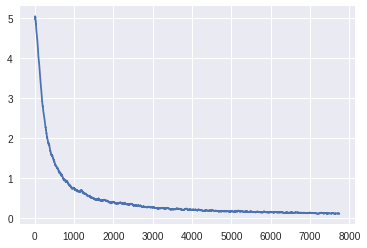

In [70]:
learn.sched.plot_loss()

In [0]:
# error for some reason ???
'''
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(95)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(95)),[learn.sched.losses[i] for i in range(97,95*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(95)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
'''


### Choosing a learning rate
The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [72]:
lrf=learn.lr_find()

 60%|██████    | 1558/2583 [04:22<02:45,  6.21it/s, loss=0.343]

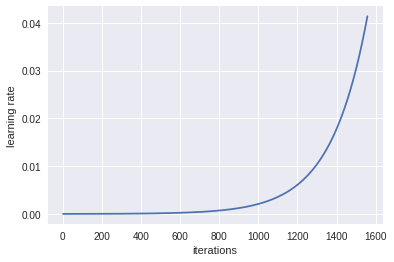

In [73]:
# Our learn object contains an attribute sched that contains our learning rate scheduler, and has some convenient plotting functionality including this one:
learn.sched.plot_lr()

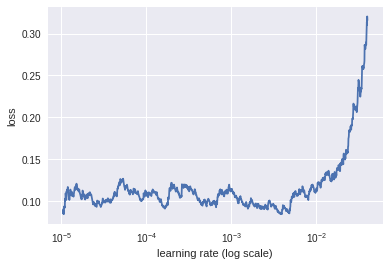

In [74]:
learn.sched.plot()

In [0]:
lrate = 0.002

The loss is still clearly improving at lr=0.002, so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

### Augment data set
If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.


In [0]:
from sklearn import metrics

In [0]:
def get_data(arch, sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    data = ImageClassifierData.from_paths(PATH, trn_name = train_dir, val_name=val_dir, tfms=tfms, bs=bs)
    return data

In [0]:
#??tfms_from_model
#??ConvLearner

In [0]:
# start with smaller image size (larger batch), e.g. 32, 64,  100
sz = 32
bs = 32

In [0]:
data = get_data(arch, sz, bs)

In [0]:
def get_augs():
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

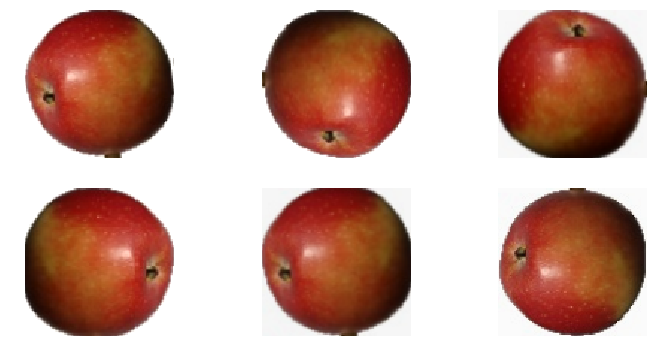

In [89]:
# plot augmented sample image
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [0]:
learn = ConvLearner.pretrained(arch, data)

In [91]:
# cycle_len - learning rate annealing used by stochastic gradient descent with restarts (SGDR),
%time vals_s2s, ep_vals_s2s = learn.fit(lrate, 3, cycle_len=1, cycle_mult=2, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.531334   0.301648   0.940045  
    1      0.280985   0.137207   0.963393  
    2      0.239988   0.126842   0.965482  
    3      0.193754   0.097412   0.968653  
    4      0.152695   0.090641   0.971824  
    5      0.14436    0.085046   0.970166  
    6      0.138584   0.082244   0.973409  
CPU times: user 49min 1s, sys: 24min 29s, total: 1h 13min 31s
Wall time: 1h 8min 39s


What is that cycle_len parameter? What we've done here is used a technique called stochastic gradient descent with restarts (SGDR), a variant of learning rate annealing, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is refered to as the number of cycles, and is what we're actually passing as the 2nd parameter to fit(). So here's what our actual learning rates looked like:


In [0]:
# if Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).

# in our case we are skipping this
# learn = ConvLearner.pretrained(arch, data)
# learn.fit(1e-1, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

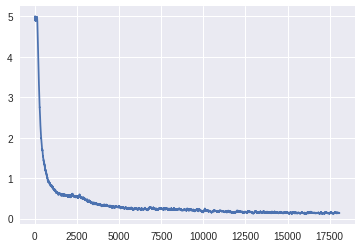

In [93]:
learn.sched.plot_loss()

In [0]:
# plot training and validation loss
#plot_ep_vals(ep_vals_s2s)

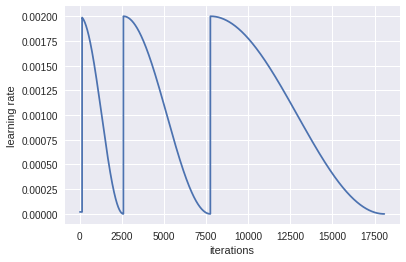

In [95]:
learn.sched.plot_lr()

In [0]:
learn.save('32_pre')

In [0]:
learn.load('32_pre')

###Fine-tuning and differential learning rate annealing
Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) unfreeze().


In [0]:
learn.unfreeze()
# keep batch normalization moving avg not be updated. Very important!!!
#learn.ns_freeze(True)

ote that the other layers have already been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.

In [105]:
lr=np.array([lrate/100, lrate/10, lrate])
% time vals_s2s, ep_vals_s2s = learn.fit(lr, 3, cycle_len=1, cycle_mult=2, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.131912   0.046306   0.984651  
    1      0.071093   0.026654   0.989839  
    2      0.059104   0.026202   0.990992  
    3      0.042233   0.025959   0.991353  
    4      0.028838   0.023853   0.992145  
    5      0.030789   0.023547   0.990272  
    6      0.029234   0.021237   0.990488  
CPU times: user 1h 6min 49s, sys: 33min 20s, total: 1h 40min 9s
Wall time: 1h 35min 27s


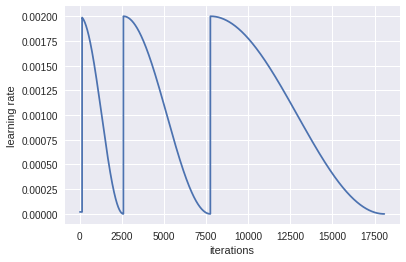

In [106]:
#Another trick we've used here is adding the cycle_mult parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the final layers. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set lr=np.array([1e-4,1e-3,1e-2]).

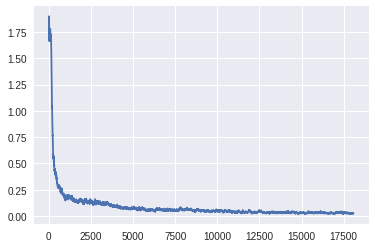

In [107]:
learn.sched.plot_loss()

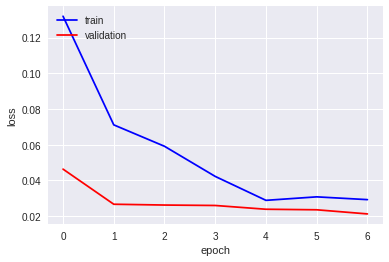

In [108]:
plot_ep_vals(ep_vals_s2s)

In [0]:
learn.save('32f_all')

In [0]:
learn.load('32f_all')

###Increase image size

In [0]:
sz = 64
bs = 16

In [0]:
data = get_data(arch, sz, bs)
learn.set_data(data)

In [113]:
learn.freeze()
%time vals_s2s, ep_vals_s2s = learn.fit(lr, 3, cycle_len=1, cycle_mult=2, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.168238   0.103546   0.968869  
    1      0.103922   0.094991   0.9724    
    2      0.119685   0.091284   0.974274  
    3      0.08849    0.080747   0.975499  
    4      0.091749   0.078796   0.978381  
    5      0.075739   0.0778     0.977661  
    6      0.088498   0.078091   0.977877  
CPU times: user 45min 15s, sys: 22min 8s, total: 1h 7min 24s
Wall time: 1h 3min 24s


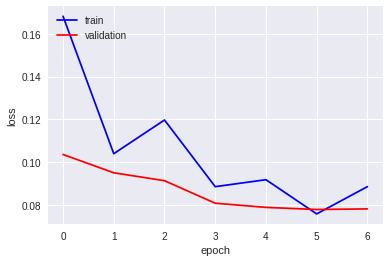

In [114]:
plot_ep_vals(ep_vals_s2s)

In [115]:
learn.unfreeze()
%time vals_s2s, ep_vals_s2s = learn.fit(lr, 3, cycle_len=1, cycle_mult=2, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.14757    0.069408   0.976436  
    1      0.076022   0.033155   0.985371  
    2      0.053192   0.036509   0.985732  
    3      0.058927   0.041799   0.984002  
    4      0.045897   0.040927   0.986092  
    5      0.0459     0.031807   0.987461  
    6      0.034697   0.034992   0.987245  
CPU times: user 1h 3min 25s, sys: 30min 38s, total: 1h 34min 4s
Wall time: 1h 30min 58s


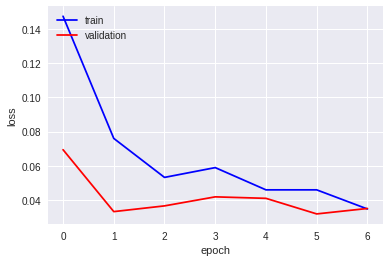

In [116]:
plot_ep_vals(ep_vals_s2s)

In [0]:
learn.save(f'{sz}')

In [0]:
learn.load(f'{sz}')

In [0]:
sz = 100
bs = 16

In [0]:
data = get_data(arch, sz, bs)
learn.set_data(data)

In [121]:
learn.freeze()
%time vals_s2s, ep_vals_s2s = learn.fit(lr, 3, cycle_len=1, cycle_mult=2, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.112863   0.054191   0.979607  
    1      0.060722   0.043795   0.98148   
    2      0.05924    0.043087   0.983354  
    3      0.045558   0.037789   0.983714  
    4      0.044965   0.040318   0.982417  
    5      0.047252   0.034955   0.986308  
    6      0.035406   0.031369   0.986308  
CPU times: user 49min 45s, sys: 23min 31s, total: 1h 13min 16s
Wall time: 1h 8min 52s


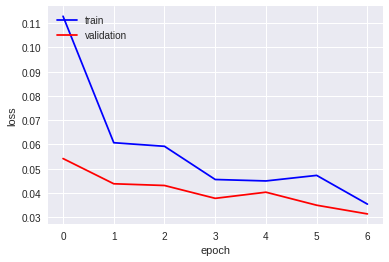

In [122]:
plot_ep_vals(ep_vals_s2s)

In [123]:
learn.unfreeze()
%time vals_s2s, ep_vals_s2s = learn.fit(lr, 4, cycle_len=1, cycle_mult=2, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.027994   0.017083   0.990992  
    1      0.018749   0.015241   0.992217  
    2      0.026642   0.015948   0.990776  
    3      0.022562   0.01707    0.992145  
    4      0.014608   0.015192   0.991425  
    5      0.013369   0.015519   0.991713  
    6      0.021676   0.016192   0.991208  
CPU times: user 1h 8min 2s, sys: 32min 1s, total: 1h 40min 4s
Wall time: 1h 35min 45s


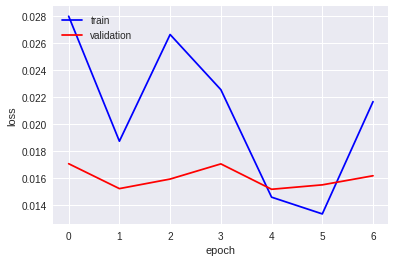

In [124]:
plot_ep_vals(ep_vals_s2s)

In [0]:
learn.save(f'{sz}')

In [0]:
learn.load(f'{sz}')

###Final Layer fitting with TTA

In [0]:
# frezzing all early layers, and training few more epochs on last layer
learn.freeze()


In [127]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 100, 100]),
                           ('output_shape', [-1, 64, 50, 50]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 50, 50]),
                           ('output_shape', [-1, 64, 50, 50]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 50, 50]),
                           ('output_shape', [-1, 64, 50, 50]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 50, 50]),
                           ('output_shape', [-1, 64, 25, 25]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 25, 25]),
        

In [128]:
%time log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

CPU times: user 8min 26s, sys: 4min 17s, total: 12min 44s
Wall time: 11min 30s


(0.9903437342365065, 0.01707189604518526)

In [0]:
learn.save('final')

In [0]:
learn.load('final')

## Analyzing Results
### Confusion matrix

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 164 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 127   0]
 [  0   0   0 ...   0   0 249]]


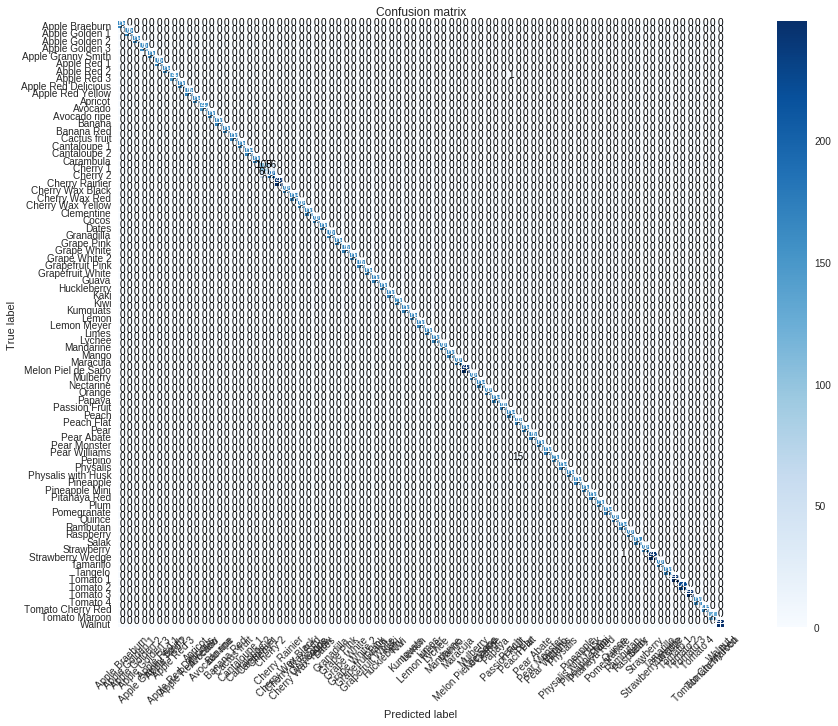

In [133]:
plot_confusion_matrix(cm, data.classes, figsize=(15,10))

## Analyzing results: looking at pictures - needs chamnge for multi-class classification !!!

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [134]:
# This is the label for a val data
data.val_y

array([ 0,  0,  0, ..., 80, 80, 80])

In [135]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['Apple Braeburn',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Red',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Clementine',
 'Cocos',
 'Dates',
 'Granadilla',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'Mandarine',
 'Mango',
 'Maracuja',
 'Melon Piel de Sapo',
 'Mulberry',
 'Nectarine',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Peach Flat',
 'Pear',
 'Pear Abate',
 'Pear Monster',
 'Pear Williams',
 'Pepino',
 'Physalis',
 'Physalis with Husk',
 'Pineapple',
 'Pineapple Mini',
 'Pitahaya Red',
 'Plum',
 'Pomegr

In [136]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(13877, 81)

In [137]:
log_preds[:10]

array([[ -0.00001, -25.88142, -24.72782, -16.87963, -20.47662, -19.2859 , -12.5705 , -16.34259, -23.90421,
        -21.30462, -17.75864, -20.46   , -21.59357, -24.43715, -26.82949, -23.54965, -31.69608, -27.69977,
        -20.92323, -15.74033, -16.16596, -20.67085, -23.11348, -17.805  , -19.46556, -22.93199, -21.81578,
        -27.16835, -17.5208 , -20.25487, -27.83451, -22.0838 , -20.01659, -20.98487, -25.25742, -28.29276,
        -21.06266, -24.61422, -22.63979, -25.4978 , -24.80354, -23.17834, -23.49196, -27.84945, -22.50541,
        -23.90936, -25.72342, -21.50662, -12.751  , -15.99869, -21.52052, -23.25915, -20.77021, -19.59039,
        -21.6381 , -26.25138, -26.86565, -25.98547, -22.53934, -24.11293, -25.85317, -20.4441 , -22.79029,
        -25.25269, -22.96713, -22.49759, -23.12791, -20.52794, -28.43306, -24.94351, -15.1738 , -23.06254,
        -24.16361, -21.96493, -22.46722, -24.16371, -27.15817, -23.52807, -23.61972, -25.04851, -24.56156],
       [ -0.00001, -28.05006, -26.31

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


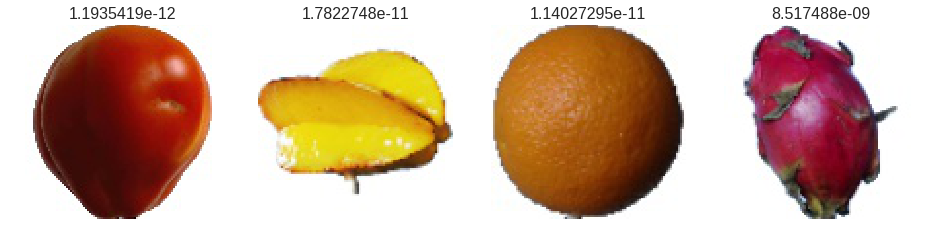

In [142]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


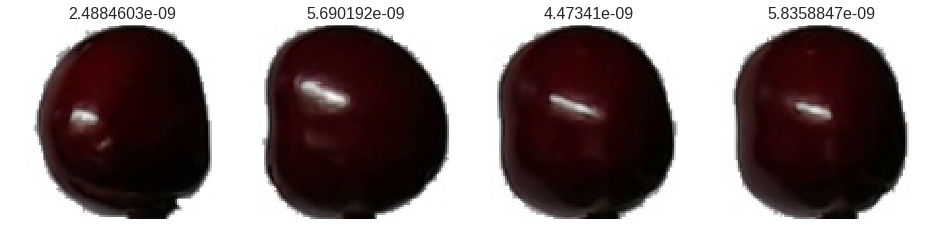

In [143]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


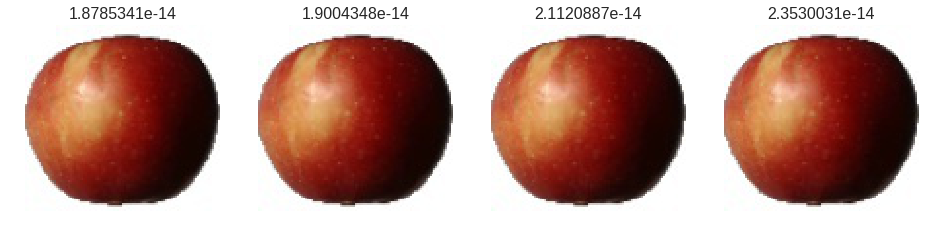

In [145]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


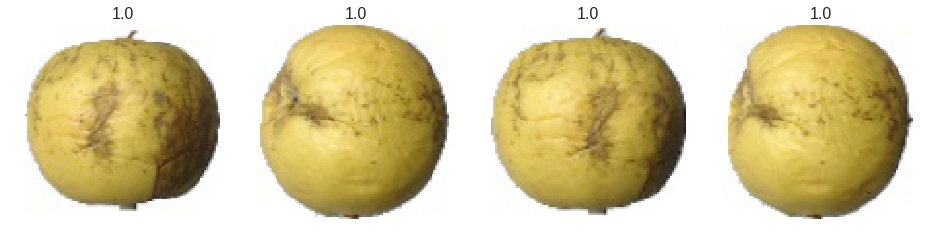

In [146]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [147]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect cats
Not Found.


In [148]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most incorrect dogs
Not Found.


Most uncertain predictions


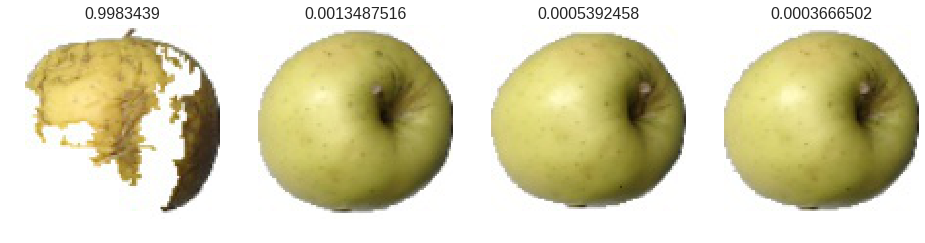

In [149]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")